In [345]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns

# Import first data and clean it

In [346]:
df = pd.read_csv('raw_sales.csv')
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In order to access to the time, we need to convert the type of the column 'datesold' from object to datetime.

In [348]:
df['datesold'] = pd.to_datetime(df['datesold'], infer_datetime_format=True)

In [349]:
df.shape

(29580, 5)

In [350]:
df.isnull().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

Let's drop the column 'postcode' which is useless for our work.

In [351]:
df.drop('postcode', axis = 1, inplace= True)

We need to verify that the column 'bedrooms' has only value from 1 to 5. If there is another value, we will drop the value.

In [352]:
df['bedrooms'].unique()

array([4, 3, 5, 1, 2, 0])

In [353]:
# We do not have houses or units without bedrooms so we can drop it
df = df[df['bedrooms']!= 0]

In [354]:
df.shape

(29550, 4)

# EDA

### Price depending on the number of bedrooms and type of property

Let's do some visualization to see how the mean price varies depending on the number of bedrooms and the type of property.

First, let's see the proportion of houses and units in the data.

([<matplotlib.patches.Wedge at 0x163887350>,
 [Text(-0.9472029821014432, 0.5592910786863431, 'house'),
  Text(0.9472030082837474, -0.5592910343445704, 'unit')],
 [Text(-0.5166561720553325, 0.3050678611016417, '83.0%'),
  Text(0.5166561863365894, -0.3050678369152202, '17.0%')])

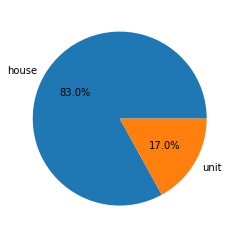

In [355]:
plt.pie(df['propertyType'].value_counts(), labels=['house','unit'], autopct='%1.1f%%')

It seems that more than 80% of the data is for house property.

It is also very important to see the number of different bedrooms that are in each type of property in order to better understand the performance of the future models on each time series. Indeed, if we don't have enough data on a particular size of property, it is more likely that we forecast poorly.

(array([2, 1, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

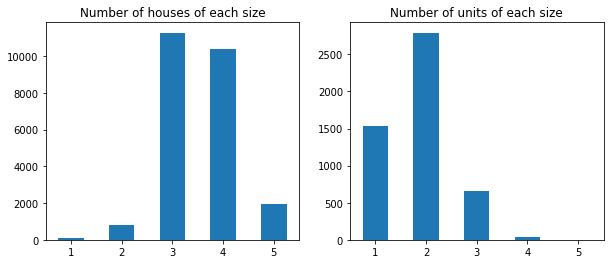

In [362]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(1,2,1)



ax = df[df['propertyType']=='house']['bedrooms'].value_counts().plot(kind='bar')
plt.title('Number of houses of each size')
plt.xticks(rotation = 0)

ax2 = f.add_subplot(1,2,2)
ax2 = df[df['propertyType']=='unit']['bedrooms'].value_counts().plot(kind='bar')
plt.title('Number of units of each size')
plt.xticks(rotation = 0)



It seems that for houses with 1,2 and 5 bedrooms, we do not have enough data compared to 3 and 4 bedrooms. In the units, it seems that 4 and 5 bedrooms size sales are not well represented compared to the ones with 1 and 2 bedrooms. Once again, the final forecast would probably perform well on those which have the more data.

Now, let's visualize the mean price for each type of property.

Text(0.5, 1.0, 'Mean price for each kind of property and number of bedroom')

<Figure size 432x288 with 0 Axes>

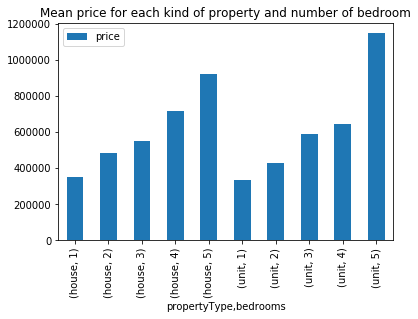

In [357]:
plt.figure()
df.groupby(['propertyType','bedrooms']).mean().plot(kind = 'bar')
plt.title('Mean price for each kind of property and number of bedroom')

We can see that the price is increasing with the number of bedrooms. 

Now, let's compare the statistics of the price for each property:

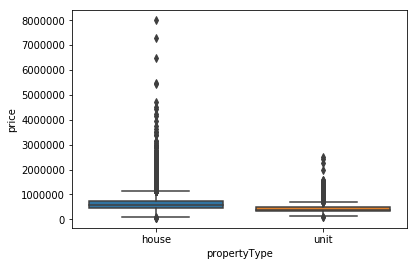

In [358]:
sns.boxplot(data = df, x='propertyType', y = 'price')

In the boxplot above, we can observe that the price of houses has more outliers and the median price of all the houses is higher than the median price of all units. It is important to identify that there are many outliers because this would allow us to choose the most appropriate metric to evualte the future models.


In [359]:
df['price'].describe()

count    2.955000e+04
mean     6.098047e+05
std      2.817045e+05
min      5.650000e+04
25%      4.400000e+05
50%      5.500000e+05
75%      7.050000e+05
max      8.000000e+06
Name: price, dtype: float64

### Evolution of the price

Now, we will focus on the evolution of the mean price of every type of properties.

To do so, we will first group by the mean price for each month by creating a new dataframe 'dfm'.

In [360]:
dfm = df.set_index('datesold')
dfm = dfm.resample('M').mean()
dfm.head()

,price,bedrooms
datesold,,
2007-02-28,407500.000000,3.500000
2007-03-31,339333.333333,3.333333
2007-04-30,798000.000000,3.666667
2007-05-31,339500.000000,3.000000
2007-06-30,520333.333333,3.333333


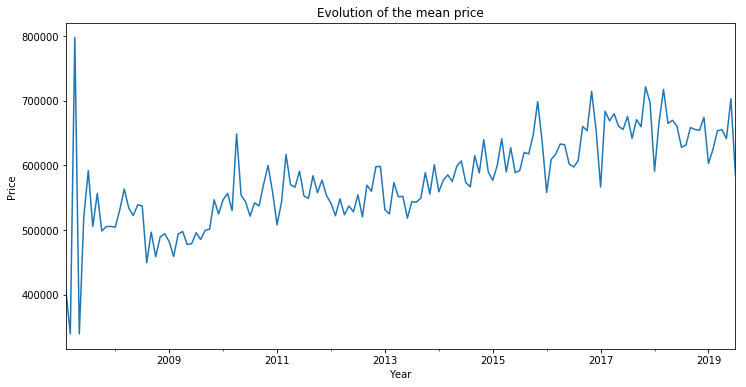

In [361]:
fig, ax = plt.subplots(figsize=(12,6))
dfm['price'].plot()
plt.title('Evolution of the mean price')
plt.ylabel('Price')
plt.xlabel('Year')
plt.show()

We can observe that in late 2007, there were a lot of variation of the price. It is coherent with the financial crisis that took place at this time period. 

# Second Dataset

Now that we have a better overall insight of the data, we will focus on the clean dataset.

In [364]:
# Import the dataset
df = pd.read_csv('ma_lga_12345.csv')

In [365]:
# Transform the data in the datetime type
df['saledate'] = pd.to_datetime(df['saledate'])

In [366]:
df.head()

,saledate,MA,type,bedrooms
0,2007-09-30,441854,house,2
1,2007-12-31,441854,house,2
2,2008-03-31,441854,house,2
3,2008-06-30,441854,house,2
4,2008-09-30,451583,house,2


In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   saledate  347 non-null    datetime64[ns]
 1   MA        347 non-null    int64         
 2   type      347 non-null    object        
 3   bedrooms  347 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 11.0+ KB


In [368]:
df.isnull().sum()

saledate    0
MA          0
type        0
bedrooms    0
dtype: int64

# EDA with new data

Before jumping into complex models, let's understand the new data. First, we will analyse the number of different bedrooms size for each property.

([<matplotlib.patches.Wedge at 0x15cc91bd0>,
 [Text(-0.26138727775730597, 1.0684927192202225, 'house'),
  Text(0.261387277757306, -1.0684927192202225, 'unit')],
 [Text(-0.14257487877671232, 0.5828142104837577, '57.6%'),
  Text(0.14257487877671238, -0.5828142104837577, '42.4%')])

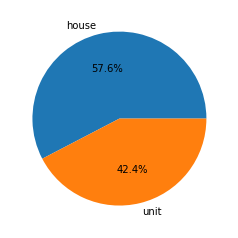

In [370]:
plt.pie(df['type'].value_counts(), labels=['house','unit'], autopct='%1.1f%%')

Text(0.5, 0, 'Number of bedrooms')

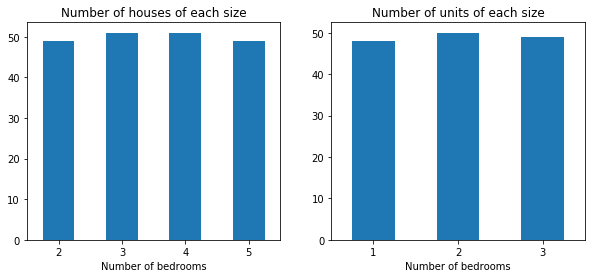

In [369]:
# Plot the bar graph for each property and number of bedrooms
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(1,2,1)

ax = df[df['type']=='house']['bedrooms'].value_counts().plot(kind='bar')
plt.title('Number of houses of each size')
plt.xticks(rotation = 0)
plt.xlabel('Number of bedrooms')

ax2 = f.add_subplot(1,2,2)
ax2 = df[df['type']=='unit']['bedrooms'].value_counts().plot(kind='bar')
plt.title('Number of units of each size')
plt.xticks(rotation = 0)
plt.xlabel('Number of bedrooms')

In this cleaned dataset, we don't have houses with 1 bedroom anymore as well as units with 4 and 5 bedrooms. Moreover, it seems that the proportion of each size of property is almost equal and thus well balanced.

# Dataset transformation

In order to forecast the price for the 8 future quarters for each type and size of property, we need to modify the dataframe. Indeed, we need a dataframe with each column being the mean price of a particular size and type of property. Moreover, the dataframe should be grouped by quarters.

We will thus create a pivot table for houses and a pivot table for units where the columns would be the mean price for each number of bedroom. For missing values, we will use a linear interpolation.

In [8]:
# Create the pivot table for houses
df_house = df[df.type=='house']
df_house = df_house.pivot(index='saledate', columns='bedrooms', values='MA').interpolate(method='linear', limit_direction='both')
df_house.head()

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,441854.0,421291.0,548969.0,735904.0
2007-06-30,441854.0,421291.0,548969.0,735904.0
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0


In [9]:
# Create the pivot table for units
df_unit = df[df.type=='unit']
df_unit = df_unit.pivot(index='saledate', columns='bedrooms', values='MA').interpolate(method='linear', limit_direction='both')
df_unit.head()

bedrooms,1,2,3
saledate,,,
2007-06-30,326076.0,368817.0,518911.0
2007-09-30,326076.0,368817.0,518911.0
2007-12-31,326076.0,368817.0,518911.0
2008-03-31,326076.0,368817.0,518911.0
2008-06-30,326076.0,373482.0,518911.0


Then we rename the columns and merge the datasets on the index.

In [10]:
# Rename the columns for a better understanding
df_h = df_house.copy()
df_h = df_h.rename(columns={2: 'bed_2_house', 3: 'bed_3_house', 4: 'bed_4_house', 5:'bed_5_house'})
df_u = df_unit.copy()
df_u = df_u.rename(columns={1: 'bed_1_unit', 2: 'bed_2_unit', 3: 'bed_3_unit'})

In [11]:
# Merge the two pivot tables
df_piv = pd.merge(df_h, df_u, left_index=True, right_index=True)
df_piv.head()

bedrooms,bed_2_house,bed_3_house,bed_4_house,bed_5_house,bed_1_unit,bed_2_unit,bed_3_unit
saledate,,,,,,,
2007-06-30,441854.0,421291.0,548969.0,735904.0,326076.0,368817.0,518911.0
2007-09-30,441854.0,421291.0,548969.0,735904.0,326076.0,368817.0,518911.0
2007-12-31,441854.0,421291.0,548969.0,735904.0,326076.0,368817.0,518911.0
2008-03-31,441854.0,416031.0,552484.0,735904.0,326076.0,368817.0,518911.0
2008-06-30,441854.0,419628.0,559580.0,735904.0,326076.0,373482.0,518911.0


Let's see the evolution of the price for each type of size of property.

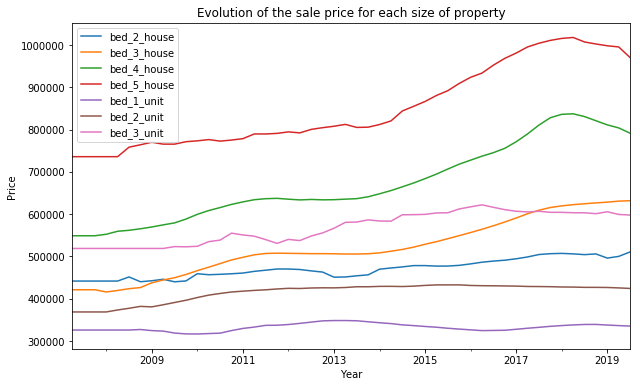

In [371]:
# Plot the evolution of the sale price 
df_piv.plot(figsize = (10,6))
plt.title('Evolution of the sale price for each size of property')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

We can identify a trend for some properties. For example, houses with 5, 4 and 3 bedrooms seem to have a trend (the price increases with time) whereas units seem to have less trend (the price remains more or less constant over time). 

# Stationarity

The trends are really important in time series since it can impact negatively the future models since we will have a high variance (the model will overfit) and thus we will forecast poorly. In time series, trends are also refered as non stationarity. Thus, we must ensure that each of our variables are stationary. 

To do so, we will use the Dickey-Fuller test. The null hypothesis of this test states that a there exists a trend in the time series. The alternative hypothesis is that the data is stationary. Thus, we will compute the p-value of each feature and see if we can reject or not the hypothesis.

In [13]:
# We use the adfuller package to conduct this test

ad_fuller_result_1 = adfuller(df_piv.iloc[:,0])

print('Houses with 2 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df_piv.iloc[:,1])

print('Houses with 3 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
                              
print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df_piv.iloc[:,2])

print('Houses with 4 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')
                              
print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df_piv.iloc[:,3])

print('Houses with 5 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')       

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df_piv.iloc[:,4])

print('Units with 1 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(df_piv.iloc[:,5])

print('Units with 2 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

print('\n---------------------\n')

ad_fuller_result_7 = adfuller(df_piv.iloc[:,6])

print('Units with 3 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

Houses with 2 bedrooms
ADF Statistic: -0.31257534251388447
p-value: 0.9237043075806377

---------------------

Houses with 3 bedrooms
ADF Statistic: 1.441019142424272
p-value: 0.9972927464515485

---------------------

Houses with 4 bedrooms
ADF Statistic: -1.7403520709654716
p-value: 0.4104508846710465

---------------------

Houses with 5 bedrooms
ADF Statistic: -2.859784574801262
p-value: 0.05022835011693851

---------------------

Units with 1 bedrooms
ADF Statistic: -2.438301235556275
p-value: 0.13121661381663402

---------------------

Units with 2 bedrooms
ADF Statistic: -3.2368135156523583
p-value: 0.017950241148052177

---------------------

Units with 3 bedrooms
ADF Statistic: -1.4908085703299225
p-value: 0.5380532087270428


We can see that most of the p-values are higher than 0.05 so we can't reject the null hypothesis. 

One method to make the time series stationary is to differentiate the features. Thus, instead of taking the price for each type of size and property, we will differentiate the price with their past prices. We will differentiate using the period that would allow us to reject the null hypothesis.

In [14]:
# We differentiate each feature to reject the null hypothesis

ad_fuller_result_1 = adfuller(df_piv.iloc[:,0].diff()[1:])

print('Houses with 2 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df_piv.iloc[:,1].diff()[1:])

print('Houses with 3 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
                              
print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df_piv.iloc[:,2].diff(periods=9)[9:])

print('Houses with 4 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')
                              
print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df_piv.iloc[:,3].diff(periods=6)[6:])

print('Houses with 5 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')       

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df_piv.iloc[:,4].diff()[1:])

print('Units with 1 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(df_piv.iloc[:,5].diff(periods=5)[5:])

print('Units with 2 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

print('\n---------------------\n')

ad_fuller_result_7 = adfuller(df_piv.iloc[:,6].diff(periods=11)[11:])

print('Units with 3 bedrooms')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

Houses with 2 bedrooms
ADF Statistic: -6.627865053538313
p-value: 5.814569479547628e-09

---------------------

Houses with 3 bedrooms
ADF Statistic: -3.866652132742023
p-value: 0.002294447137484246

---------------------

Houses with 4 bedrooms
ADF Statistic: -3.54556309847969
p-value: 0.0068912006702520415

---------------------

Houses with 5 bedrooms
ADF Statistic: -2.9866974684824856
p-value: 0.03615550279200495

---------------------

Units with 1 bedrooms
ADF Statistic: -2.99736869204364
p-value: 0.03514086309071088

---------------------

Units with 2 bedrooms
ADF Statistic: -3.447019585359521
p-value: 0.009456673274864512

---------------------

Units with 3 bedrooms
ADF Statistic: -2.9051341858173823
p-value: 0.04475421074570151


Now we know the level of differentiation that we need for each feature to get each time series stationary.

# Models

## VAR model

As we work with a multivariate time series, we need to use one of the model from the VARMAX family to forecast the future prices. Before implementing the model, we need to select the optimal laglength. One way to do so, is to use some criteria such as the AIC (Akaike information criterion) or the BIC (Schwartcz information criterion) and select the optimal value of the lag.

Moreover, we will split the data into the training set and testing set and find the optimal lag on the training set. The test set will be the 5 last quarters of our dataset.

In [380]:
# We use the VAR package to get the AIC, BIC, FPE and HQIC. 

# We split the data into the training and testing set
train_df_piv=df_piv[:-5]
test_df_piv=df_piv[-5:]

# We find the optimal lag on the training set that we differentiate
model_var_piv = VAR(train_df_piv.diff()[1:])
sorted_order_piv=model_var_piv.select_order(maxlags=2)
print(sorted_order_piv.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       115.3       115.6   1.168e+50       115.4
1       112.9      115.2*   1.142e+49       113.8
2      112.0*       116.3  5.398e+48*      113.6*
-------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


### Training

It seems that the optimal lag value is 6. Now, we can run the VAR model on the training set and assess its performance on the test set. We do not need to differentiate the values because the package VAR has an argument called 'enforce_stationarity' that can make the times series stationary.

In [381]:
# We implement the VAR model with the lag equal to 4
var_model_piv = VARMAX(train_df_piv, order=(2,0),enforce_stationarity= True)

# Then we fit the model
fitted_model_piv = var_model_piv.fit(disp=False)
print(fitted_model_piv.summary())

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                                                     Statespace Model Results                                                                     
Dep. Variable:     ['bed_2_house', 'bed_3_house', 'bed_4_house', 'bed_5_house', 'bed_1_unit', 'bed_2_unit', 'bed_3_unit']   No. Observations:                   45
Model:                                                                                                             VAR(2)   Log Likelihood               -5654.807
                                                                                                              + intercept   AIC                          11575.613
Date:                                                                                                    Sun, 17 Apr 2022   BIC                          11815.899
Time:                                                                                                            23:55:25   HQIC                         11665.190
Sample:               

### Evaluate the model

In [382]:
# We specify the number of forecast
n_forecast = 5

# We specify the start date and ending date of the forecast
predict_piv1 = fitted_model_piv.get_prediction(start=len(train_df_piv),end=len(train_df_piv) + n_forecast-1)

# We predict the mean price for each feature and rename it
predictions_piv1=predict_piv1.predicted_mean

predictions_piv1.columns=['pred_2_house','pred_3_house',
                          'pred_4_house','pred_5_house',
                          'pred_1_unit','pred_2_unit','pred_3_unit']
predictions_piv1

,pred_2_house,pred_3_house,pred_4_house,pred_5_house,pred_1_unit,pred_2_unit,pred_3_unit
2018-09-30,507853.187757,607437.870086,821083.633247,1.026381e+06,343480.300229,429602.891771,619498.305927
2018-12-31,510486.595564,608902.384395,816951.344690,1.022523e+06,345802.142260,430672.167536,616555.107191
2019-03-31,501553.490782,586408.237173,792013.277248,9.979616e+05,340865.930097,421996.545741,607373.945852
2019-06-30,500013.512236,579419.276544,781497.661670,9.873634e+05,339417.709041,418962.581744,602242.806067
2019-09-30,494821.215617,565941.750101,764774.431269,9.696503e+05,337592.361716,415104.088978,596379.205412


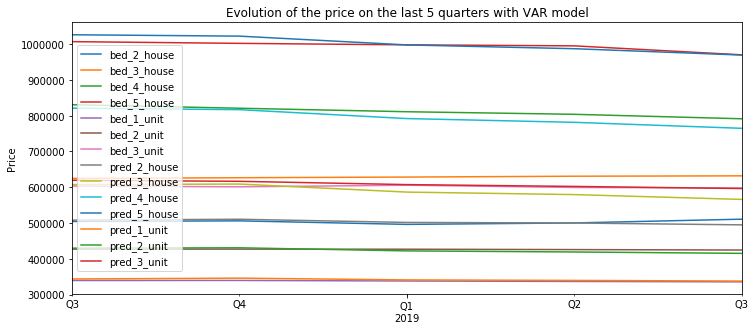

In [383]:
# Then we concatenate the result with the test set in order to assess the performance
test_vs_pred_piv1=pd.concat([test_df_piv,predictions_piv1],axis=1)

# We plot the evolution of the price in the test set and the respective prediction
test_vs_pred_piv1.plot(figsize=(12,5))
plt.title('Evolution of the price on the last 5 quarters with VAR model')
plt.ylabel('Price')
plt.legend()

We can see that the prediction seems to be relatively close to the real value. Let's use some metrics to validate our assumption of the model. We will use the mean absolute error (MAE) as the evaluation metric since it is robust to the outliers. We will show the mean absolute error and the mean absolute percentage error (MAPE). If the error of a feature is less than 10%, we can state that the model perfoms well on this particular feature.

In [308]:
# Create the mean absolute percentage error function

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [404]:
print('For a house with 2 bedrooms')
bed_2_piv = mean_absolute_error(predictions_piv1.iloc[:,0],test_df_piv.iloc[:,0])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,0]),bed_2_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,0],predictions_piv1.iloc[:,0]),1))+ '%.')

print('\n')

print('For a house with 3 bedrooms')
bed_3_piv = mean_absolute_error(predictions_piv1.iloc[:,1],test_df_piv.iloc[:,1])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,1]),bed_3_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,1],predictions_piv1.iloc[:,1]),1))+ '%.')

print('\n')

print('For a house with 4 bedrooms')
bed_4_piv = mean_absolute_error(predictions_piv1.iloc[:,2],test_df_piv.iloc[:,2])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,2]),bed_4_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,2],predictions_piv1.iloc[:,2]),1))+ '%.')

print('\n')

print('For a house with 5 bedrooms')
bed_5_piv = mean_absolute_error(predictions_piv1.iloc[:,3],test_df_piv.iloc[:,3])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,3]),bed_5_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,3],predictions_piv1.iloc[:,3]),1))+ '%.')

print('\n')


print('For a unit with 1 bedroom')
bed_1_unit_piv = mean_absolute_error(predictions_piv1.iloc[:,4],test_df_piv.iloc[:,4])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,4]),bed_1_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,4],predictions_piv1.iloc[:,4]),1))+ '%.')

print('\n')

print('For a unit with 2 bedrooms')
bed_2_unit_piv = mean_absolute_error(predictions_piv1.iloc[:,5],test_df_piv.iloc[:,5])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,5]),bed_2_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,5],predictions_piv1.iloc[:,5]),1))+ '%.')

print('\n')

print('For a unit with 3 bedrooms')
bed_3_unit_piv = mean_absolute_error(predictions_piv1.iloc[:,6],test_df_piv.iloc[:,6])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,6]),bed_3_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,6],predictions_piv1.iloc[:,6]),1))+ '%.')



For a house with 2 bedrooms
Mean value of the price is : 503464.4.  
The Mean Absolute Error is : 5895.309249923285
The MAPE is : 1.2%.


For a house with 3 bedrooms
Mean value of the price is : 628464.4. 
The Mean Absolute Error is : 38842.49634011567
The MAPE is : 6.2%.


For a house with 4 bedrooms
Mean value of the price is : 811628.6.  
The Mean Absolute Error is : 16364.530375425355
The MAPE is : 2.0%.


For a house with 5 bedrooms
Mean value of the price is : 994640.8. 
The Mean Absolute Error is : 9651.696548099653
The MAPE is : 1.0%.


For a unit with 1 bedroom
Mean value of the price is : 337681.6.  
The Mean Absolute Error is : 3750.088668630342
The MAPE is : 1.1%.


For a unit with 2 bedrooms
Mean value of the price is : 426129.2. 
The Mean Absolute Error is : 5409.168568635662
The MAPE is : 1.3%.


For a unit with 3 bedrooms
Mean value of the price is : 601461.6.  
The Mean Absolute Error is : 7550.191924977186
The MAPE is : 1.3%.


In [374]:
comparison_data_first = {'House with 2 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,0],predictions_piv1.iloc[:,0]),1))+'%'
                                         ],
                    'House with 3 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,1],predictions_piv1.iloc[:,1]),1))+'%'
                                         ],
                   'House with 4 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,2],predictions_piv1.iloc[:,2]),1))+'%'],
                   'House with 5 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,3],predictions_piv1.iloc[:,3]),1))+'%'],
                   'Unit with 1 bedroom': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,4],predictions_piv1.iloc[:,4]),1))+'%'
                                         ],
                   'Unit with 2 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,5],predictions_piv1.iloc[:,5]),1))+'%'],
                  'Unit with 3 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,6],predictions_piv1.iloc[:,6]),1))+'%']}

comparison_table_first = pd.DataFrame(data=comparison_data_first, index=['VAR'])
comparison_table_first.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
VAR,1.200%,6.200%,2.000%,1.000%,1.100%,1.300%,1.300%


It seems that excpect houses with 3 bedrooms, all errors are less than 5% which means that the model performs very well on the test set. However, the model predicts poorly on for the houses with 3 bedrooms. 

Now we will use the model to forecast the 8 following quarters. We will use the same methodology as before but now, instead of working with only the training set, we will work with the entire dataset as the training set.

### Forecast

In [310]:
# We specify the number of quarters we want to forecast
n_forecast = 8

# We specify that when do we want to start the forecast 
predict_piv = fitted_model_piv.get_prediction(start=len(df_piv),end=len(df_piv) + n_forecast-1)

predictions_piv=predict_piv.predicted_mean

# We rename the columns as the name of the columns in the real dataset
predictions_piv.columns=df_piv.columns
predictions_piv

bedrooms,bed_2_house,bed_3_house,bed_4_house,bed_5_house,bed_1_unit,bed_2_unit,bed_3_unit
2019-12-31,493350.960814,560447.342251,755508.534470,959525.037270,337131.654259,413737.683107,592511.623579
2020-03-31,489659.119805,550949.212657,742502.106832,945094.773309,336023.841542,411442.987185,587944.727509
2020-06-30,488099.614976,546017.495483,733970.927523,935350.982503,335611.279781,410514.904343,584641.399870
2020-09-30,485399.284716,539098.695745,723723.101999,923631.358681,334868.729794,409156.382257,581108.936572
2020-12-31,483983.816448,534985.950901,716362.266298,914979.678767,334542.770295,408624.570586,578439.182935
2021-03-31,481992.739292,529944.249624,708344.753846,905574.129887,334042.800127,407884.956720,575757.785488
2021-06-30,480793.731807,526668.230892,702257.094215,898252.855729,333792.455798,407640.455247,573673.482180
2021-09-30,479327.719608,523023.902072,696064.010215,890819.247223,333456.389516,407300.081876,571677.017571


Finally, we can plot our forecast.

Text(0, 0.5, 'Price')

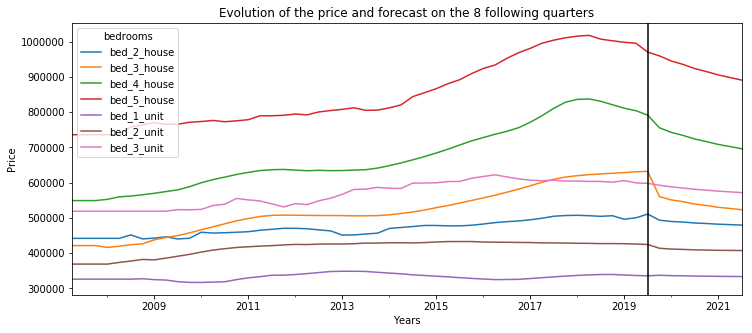

In [311]:
# We create a variable of 8 quarters for the following
date_piv = list(predictions_piv.index)

# Concatenate the real dataset with the forecast
test_vs_pred_piv=pd.concat([df_piv,predictions_piv],axis=0)


# Plot the forecast along with the previous values 
test_vs_pred_piv.plot(figsize=(12,5))
plt.axvline(x='2019-09-30', color = 'black')
plt.title('Evolution of the price and forecast on the 8 following quarters')
plt.xlabel('Years')
plt.ylabel('Price')

The black vertical line is the limit of our real dataset. The plot on the right side of this line is our forecast. We can observe that the forecast has for most of the properties, a suitable prediction for the 8 future quarters. As expected, it seems that the model has some difficulty to ensure a smooth variation with the first forecast quarter for houses with 3 bedrooms.  

## LSTM model

Now, we will focus on one of the Recurrent Neural Network (RNN) model which is the Long Short-Term Memory (LSTM) model. We want to assess the performance of this model and compare with the previous model.

Before working with this model, we need to process the data in order to have the suitable input. First, we begin to split the data as before.

In [124]:
# Split the training and testing set to the last 5 quarters 
train_df_piv=df_piv[:-5]
test_df_piv=df_piv[-5:]

In order to use the LSTM model, we need to standardize the data. We will thus use the MinMaxScaler package to do so. We will fit the scaler to the training data and transform the training and testing set.

### Process the input

In [386]:
# Standardize the train and test set
from sklearn.preprocessing import MinMaxScaler

scaler_piv = MinMaxScaler()
scaler_piv.fit(train_df_piv)
scaled_train_piv = scaler_piv.transform(train_df_piv)
scaled_test_piv = scaler_piv.transform(test_df_piv)

We will then use the TimeseriesGenerator method. The goal of the generator is to transform the multivariate time series data into samples. We need to specify the number of input of each sequence. When we fit the model on the time series generator, we will predict the outcome based on the number of inputs. For example, if the input is the price for the first 4 quarters, the generator will give the price for the 5-th quarter. Then we will take as an input the price from the second to the 5-th quarter and the generator will give us the 6-th quarter's price and so on.

In [387]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [388]:
# The input in the generator will be 2 quarters. We also specify the number of inputs.
n_input = 2
n_features = 7
generator_piv = TimeseriesGenerator(scaled_train_piv, scaled_train_piv, length=n_input, batch_size=1)


In [389]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Finally, we define the model. We will use three layers and the output would be the price for each number of bedrooms (7 outputs). The loss function is the mean aboslute error to still remain robust to the outliers and we use the Adam optimizer.

### Create and train the model

In [390]:
# Build LSTM model
model_lstm_piv = Sequential()
model_lstm_piv.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model_lstm_piv.add(LSTM(100, activation='relu'))
model_lstm_piv.add(Dense(7))
model_lstm_piv.compile(optimizer='adam', loss='mae')

# Let's look to the model
model_lstm_piv.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 100)            43200     
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dense_14 (Dense)            (None, 7)                 707       
                                                                 
Total params: 124,307
Trainable params: 124,307
Non-trainable params: 0
_________________________________________________________________


In [391]:
# Fit model with 50 epochs
model_lstm_piv.fit(generator_piv,epochs=50)

Epoch 1/50
43/43 [==============================] - 3s 5ms/step - loss: 0.3589
Epoch 2/50
43/43 [==============================] - 0s 6ms/step - loss: 0.1494
Epoch 3/50
43/43 [==============================] - 0s 6ms/step - loss: 0.1296
Epoch 4/50
43/43 [==============================] - 0s 5ms/step - loss: 0.1163
Epoch 5/50
43/43 [==============================] - 0s 5ms/step - loss: 0.1075
Epoch 6/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0849
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0768
Epoch 8/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0714
Epoch 9/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0738
Epoch 10/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0747
Epoch 11/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0664
Epoch 12/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0669
Epoch 13/50
43/43 [==============================

Let's take a look to the evolution of the loss function

Text(0.5, 1.0, 'Evolution of the loss function')

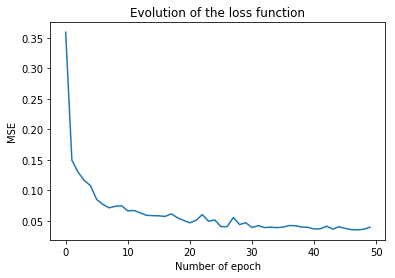

In [392]:
# Plot the evolution of the loss function
loss_per_epoch_piv = model_lstm_piv.history.history['loss']
plt.plot(range(len(loss_per_epoch_piv)),loss_per_epoch_piv)
plt.ylabel('MSE')
plt.xlabel('Number of epoch')
plt.title('Evolution of the loss function')

It seems that it remains more or less constant from 35 epochs.

Now, we want to evalute our model on the test set. To do so, we will use the training set and the generator to predict the price of the following quarter. Then, we will store all these predictions in a list and compare the values to the test set.

### Evaluate the model

In [393]:
# The list that would take the values of the predictions
test_predictions_piv = []

# Each batch is needed to predict the following quarter
first_eval_batch_piv = scaled_train_piv[-n_input:]
current_batch_piv = first_eval_batch_piv.reshape((1, n_input, n_features))

for i in range(len(test_df_piv)):
    
    # Get the prediction value from each batch
    current_pred_piv = model_lstm_piv.predict(current_batch_piv)[0]
    
    # Append the prediction into the list
    test_predictions_piv.append(current_pred_piv) 
    
    # Use the prediction to update the batch and remove the first value
    current_batch_piv = np.append(current_batch_piv[:,1:,:],[[current_pred_piv]],axis=1)
    
test_predictions_piv

[array([0.9807303 , 0.9165554 , 0.91532224, 0.9366052 , 0.6332918 ,
        0.9156141 , 0.8196353 ], dtype=float32),
 array([0.95676064, 0.892498  , 0.8895573 , 0.9096576 , 0.6251321 ,
        0.9144211 , 0.8133991 ], dtype=float32),
 array([0.90876967, 0.85183346, 0.84112495, 0.8690675 , 0.5768396 ,
        0.91085947, 0.8140852 ], dtype=float32),
 array([0.8748986 , 0.82486606, 0.80803597, 0.84267646, 0.54037005,
        0.90868473, 0.8141908 ], dtype=float32),
 array([0.8367421 , 0.7965332 , 0.7719816 , 0.81737834, 0.48846206,
        0.905352  , 0.8174679 ], dtype=float32)]

In [394]:
# Inverse the transformation of the scaler to get the real value of the price 
true_predictions_piv = scaler_piv.inverse_transform(test_predictions_piv)

# Rename the dataframe 
pred_piv = pd.DataFrame(true_predictions_piv, columns = ['pred_2_house','pred_3_house',
                                                         'pred_4_house','pred_5_house',
                                                         'pred_1_unit','pred_2_unit','pred_3_unit'])

# Update the test set to compare with the prediction
test_df_piv['pred_2_house'] = pred_piv['pred_2_house'].values
test_df_piv['pred_3_house'] = pred_piv['pred_3_house'].values
test_df_piv['pred_4_house'] = pred_piv['pred_4_house'].values
test_df_piv['pred_5_house'] = pred_piv['pred_5_house'].values
test_df_piv['pred_1_unit'] = pred_piv['pred_1_unit'].values
test_df_piv['pred_2_unit'] = pred_piv['pred_2_unit'].values
test_df_piv['pred_3_unit'] = pred_piv['pred_3_unit'].values

test_df_piv

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

bedrooms,bed_2_house,bed_3_house,bed_4_house,bed_5_house,bed_1_unit,bed_2_unit,bed_3_unit,pred_2_house,pred_3_house,pred_4_house,pred_5_house,pred_1_unit,pred_2_unit,pred_3_unit
saledate,,,,,,,,,,,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0,339220.0,426970.0,603281.0,505954.521064,605240.114962,812880.201372,999884.306658,336864.980255,427401.654373,603443.264145
2018-12-31,506001.0,626608.0,820924.0,1002323.0,339350.0,426936.0,601167.0,504345.558290,600273.828007,805451.498656,992289.174552,336605.820117,427325.318481,602800.100352
2019-03-31,496133.0,628423.0,811121.0,998136.0,337838.0,426669.0,605637.0,501124.163907,591879.240876,791487.192864,980848.933950,335072.003356,427097.432047,602870.861524
2019-06-30,500158.0,630814.0,803925.0,995363.0,336551.0,425659.0,599339.0,498850.569364,586312.224362,781946.779010,973410.675107,333913.693066,426958.283798,602881.754479
2019-09-30,510712.0,631875.0,791446.0,970268.0,335449.0,424412.0,597884.0,496289.313671,580463.336709,771551.365921,966280.450979,332265.043510,426745.042139,603219.737279


Then we can plot the real evolution of the price and the prediction.

Text(0, 0.5, 'Price')

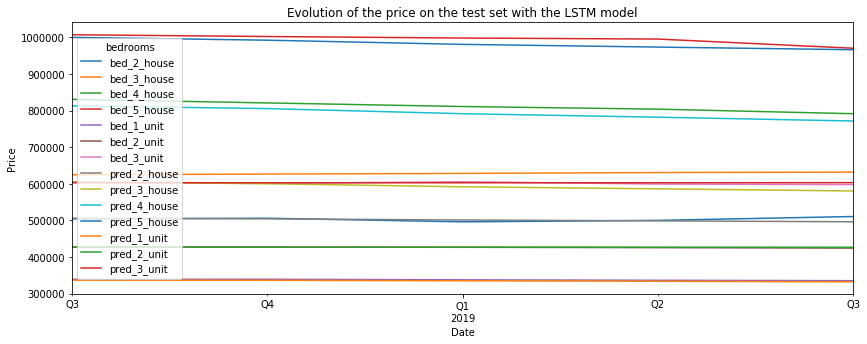

In [395]:
# Plot the test set and the prediction
test_df_piv.plot(figsize=(14,5))
plt.title('Evolution of the price on the test set with the LSTM model')
plt.xlabel('Date')
plt.ylabel('Price')

It seems that the model has some difficulties to well predict houses with 5 and 4 bedrooms. Let's evaluate the model on the test set by using the MAE as the evaluation metric.

In [396]:
print('For a house with 2 bedrooms')
bed_2_lstm_piv = mean_absolute_error(test_df_piv['pred_2_house'],test_df_piv.iloc[:,0])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,0]),bed_2_lstm_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,0],test_df_piv['pred_2_house']),1))+ '%.')

print('\n')

print('For a house with 3 bedrooms')
bed_3_lstm_piv = mean_absolute_error(test_df_piv['pred_3_house'],test_df_piv.iloc[:,1])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,1]),bed_3_lstm_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,1],test_df_piv['pred_3_house']),1))+ '%.')

print('\n')

print('For a house with 4 bedrooms')
bed_4_lstm_piv = mean_absolute_error(test_df_piv['pred_4_house'],test_df_piv.iloc[:,2])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,2]),bed_4_lstm_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,2],test_df_piv['pred_4_house']),1))+ '%.')

print('\n')

print('For a house with 5 bedrooms')
bed_5_lstm_piv = mean_absolute_error(test_df_piv['pred_5_house'],test_df_piv.iloc[:,3])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,3]),bed_5_lstm_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,3],test_df_piv['pred_5_house']),1))+ '%.')


print('\n')

print('For a unit with 1 bedroom')
bed_1_lstm_unit_piv = mean_absolute_error(test_df_piv['pred_1_unit'],test_df_piv.iloc[:,4])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,4]),bed_1_lstm_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,4],test_df_piv['pred_1_unit']),1))+ '%.')

print('\n')

print('For a unit with 2 bedrooms')
bed_2_lstm_unit_piv = mean_absolute_error(test_df_piv['pred_2_unit'],test_df_piv.iloc[:,5])
print('Mean value of the price is : {}. \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,5]),bed_2_lstm_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,5],test_df_piv['pred_2_unit']),1))+ '%.')

print('\n')

print('For a unit with 3 bedrooms')
bed_3_lstm_unit_piv = mean_absolute_error(test_df_piv['pred_3_unit'],test_df_piv.iloc[:,6])
print('Mean value of the price is : {}.  \nThe Mean Absolute Error is : {}'.format(mean(test_df_piv.iloc[:,6]),bed_3_lstm_unit_piv))
print('The MAPE is : {}' .format(round(MAPE(test_df_piv.iloc[:,6],test_df_piv['pred_3_unit']),1))+ '%.')



For a house with 2 bedrooms
Mean value of the price is : 503464.4.  
The Mean Absolute Error is : 4802.648729407787
The MAPE is : 0.9%.


For a house with 3 bedrooms
Mean value of the price is : 628464.4. 
The Mean Absolute Error is : 35630.65101709366
The MAPE is : 5.7%.


For a house with 4 bedrooms
Mean value of the price is : 811628.6.  
The Mean Absolute Error is : 18965.192435479163
The MAPE is : 2.3%.


For a house with 5 bedrooms
Mean value of the price is : 994640.8. 
The Mean Absolute Error is : 12098.091750812531
The MAPE is : 1.2%.


For a unit with 1 bedroom
Mean value of the price is : 337681.6.  
The Mean Absolute Error is : 2737.2919394671917
The MAPE is : 0.8%.


For a unit with 2 bedrooms
Mean value of the price is : 426129.2. 
The Mean Absolute Error is : 976.3461677550688
The MAPE is : 0.2%.


For a unit with 3 bedrooms
Mean value of the price is : 601461.6.  
The Mean Absolute Error is : 2687.9989461421965
The MAPE is : 0.4%.


In [400]:
comparison_data_sec = {'House with 2 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,0],test_df_piv['pred_2_house']),1))+'%'],
                    'House with 3 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,1],test_df_piv['pred_3_house']),1))+'%'],
                   'House with 4 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,2],test_df_piv['pred_4_house']),1))+'%'],
                   'House with 5 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,3],test_df_piv['pred_5_house']),1))+'%'],
                   'Unit with 1 bedroom': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,4],test_df_piv['pred_1_unit']),1))+'%'],
                   'Unit with 2 bedrooms':[
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,5],test_df_piv['pred_2_unit']),1))+'%'],
                  'Unit with 3 bedrooms':[
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,6],test_df_piv['pred_3_unit']),1))+'%']}

comparison_table_sec = pd.DataFrame(data=comparison_data_sec, index=['LSTM'])
comparison_table_sec.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
LSTM,0.9000%,5.7000%,2.3000%,1.2000%,0.8000%,0.2000%,0.4000%


We can see that all of the errors are less than 10% from the relative mean price. However, we can confirm that houses 3 bedrooms are those the model predicts poorly. 

### Forecast

Now we will use the all dataset as the training set in order to forecast the 8 following quarters. 

In [397]:
# Standardize the all dataset
scaler_forecast_piv = MinMaxScaler()
scaler_forecast_piv.fit(df_piv)
scaled_df_piv = scaler_forecast_piv.transform(df_piv)

# List that would take the values of the forecast
test_predictions_lstm_forecast_piv = []

first_eval_batch_lstm_forecast_piv = scaled_df_piv[-n_input:]
current_batch_lstm_forecast_piv = first_eval_batch_lstm_forecast_piv.reshape((1, n_input, n_features))

# For the 8 next quarters, we are predicting the price
for i in range(8):
    
    # Get the prediction value from the batch
    current_pred_lstm_forecast_piv = model_lstm_piv.predict(current_batch_lstm_forecast_piv)[0]
    
    # Append the prediction into the list
    test_predictions_lstm_forecast_piv.append(current_pred_lstm_forecast_piv) 
    
    # Use the prediction to update the batch and remove the first value
    current_batch_lstm_forecast_piv = np.append(current_batch_lstm_forecast_piv[:,1:,:],[[current_pred_lstm_forecast_piv]],axis=1)

In [398]:
# Inverse the transformation
true_predictions_lstm_forecast_piv = scaler_forecast_piv.inverse_transform(test_predictions_lstm_forecast_piv)


# The dataframe of the prediction
pred_lstm_forecast_piv = pd.DataFrame(true_predictions_lstm_forecast_piv, columns = df_piv.columns)

# We specify the 8 next quarters date
pred_lstm_forecast_piv['date'] = date_piv

# We set the index to the date as the df_house dataframe
pred_lstm_forecast_piv = pred_lstm_forecast_piv.set_index('date')

# Finally, we concatenate the dataframes 
df_cop_piv = df_piv.copy()
test_vs_pred_lstm_forecast_piv=pd.concat([df_cop_piv,pred_lstm_forecast_piv],axis=0)


In [401]:
pred_lstm_forecast_piv

bedrooms,bed_2_house,bed_3_house,bed_4_house,bed_5_house,bed_1_unit,bed_2_unit,bed_3_unit
date,,,,,,,
2019-12-31,502522.073204,595184.848512,783801.479967,973119.473443,334641.837320,426716.240747,601230.322356
2020-03-31,500658.984328,589931.738657,776140.239319,966862.719913,333682.104081,426225.533987,600484.284076
2020-06-30,497457.208312,583212.730226,764358.964777,959049.262156,331786.628900,426341.136183,602016.237947
2020-09-30,495403.299760,578680.206101,756578.971849,953653.984418,330507.949434,426218.863750,602175.347618
2020-12-31,493528.371169,574847.477374,749615.619965,949700.032286,329058.933282,426435.236492,603371.224342
2021-03-31,492152.675455,571964.825686,744532.919247,946688.378099,328018.688261,426529.348243,604017.074490
2021-06-30,491160.297857,570025.406696,740992.623330,945120.082252,327116.886817,426735.328534,604995.928154
2021-09-30,490464.990223,568646.194545,738548.835446,944073.862909,326464.374873,426868.584549,605688.233187


Text(0, 0.5, 'Price')

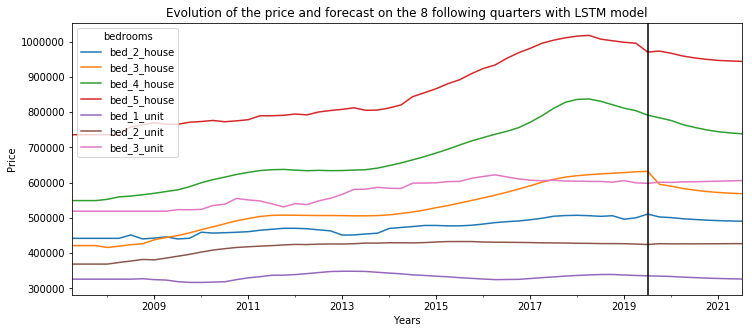

In [402]:
# Plot the forecast
test_vs_pred_lstm_forecast_piv.plot(figsize=(12,5))
plt.axvline(x='2019-09-30', color = 'black')
plt.title('Evolution of the price and forecast on the 8 following quarters with LSTM model')
plt.xlabel('Years')
plt.ylabel('Price')

As before, the vertical black line separates the real data from the forecast. As one might have expected, houses with 3 bedrooms have a suddent variation during the forecast of the first quarter. However, the others have a smoother variation and seem suitable.

## Comparison

In [403]:
# Comparaison


comparison_data = {'House with 2 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,0],predictions_piv1.iloc[:,0]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,0],test_df_piv['pred_2_house']),1))+'%'],
                    'House with 3 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,1],predictions_piv1.iloc[:,1]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,1],test_df_piv['pred_3_house']),1))+'%'],
                   'House with 4 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,2],predictions_piv1.iloc[:,2]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,2],test_df_piv['pred_4_house']),1))+'%'],
                   'House with 5 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,3],predictions_piv1.iloc[:,3]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,3],test_df_piv['pred_5_house']),1))+'%'],
                   'Unit with 1 bedroom': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,4],predictions_piv1.iloc[:,4]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,4],test_df_piv['pred_1_unit']),1))+'%'],
                   'Unit with 2 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,5],predictions_piv1.iloc[:,5]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,5],test_df_piv['pred_2_unit']),1))+'%'],
                  'Unit with 3 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,6],predictions_piv1.iloc[:,6]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,6],test_df_piv['pred_3_unit']),1))+'%']}

comparison_table = pd.DataFrame(data=comparison_data, index=['VAR' , 'LSTM'])
comparison_table.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
VAR,1.200%,6.200%,2.000%,1.000%,1.100%,1.300%,1.300%
LSTM,0.9000%,5.7000%,2.3000%,1.2000%,0.8000%,0.2000%,0.4000%


# Extension

When we use time series, the lag is a really important parameter. If we choose the model to train on a large value of lags, the model would follow the global 'trend' and would not be able to anticipate the outcome of major crisis. In this case, we know that the Covid crisis has impacted the property prices and thus the general trend over the years. If the model is trained based on many past values, it would be dificult for the model to understand recent variation. Thus, there is a tradeoff is this study: if we trained on to little past values, we will be underfitting and if we trained on many past values we will overfit. 

Let's see what the forecast would be if we had selected a higher time lag. In order to compare the two models, we will use the same time lag of 4 quarters.

## For the VARM

Now, we will consider a time lag of 4 instead of 2. Once again, the goal is to see the impact of the time lag on the forecast. 

### Training

In [412]:
# Split the data
train_df_piv=df_piv[:-5]
test_df_piv=df_piv[-5:]

# We implement the VAR model with the lag equal to 4
var_model_piv2 = VARMAX(train_df_piv, order=(4,0),enforce_stationarity= True)

# Then we fit the model
fitted_model_piv2 = var_model_piv2.fit(disp=False)
print(fitted_model_piv2.summary())

# We specify the number of quarters we want to forecast
n_forecast = 8

# We specify that when do we want to start the forecast 
predict_piv2 = fitted_model_piv2.get_prediction(start=len(df_piv),end=len(df_piv) + n_forecast-1)

predictions_piv2=predict_piv2.predicted_mean

# We rename the columns as the name of the columns in the real dataset
predictions_piv2.columns=df_piv.columns
predictions_piv2

# Concatenate the real dataset with the forecast
test_vs_pred_piv2=pd.concat([df_piv,predictions_piv2],axis=0)


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                                                     Statespace Model Results                                                                     
Dep. Variable:     ['bed_2_house', 'bed_3_house', 'bed_4_house', 'bed_5_house', 'bed_1_unit', 'bed_2_unit', 'bed_3_unit']   No. Observations:                   45
Model:                                                                                                             VAR(4)   Log Likelihood              -32396.016
                                                                                                              + intercept   AIC                          65254.032
Date:                                                                                                    Mon, 18 Apr 2022   BIC                          65671.372
Time:                                                                                                            12:30:10   HQIC                         65409.612
Sample:               

### Evaluate the model

Let's see the performance of this new model on the test set by using the metric MAPE.

In [420]:
# We specify the number of forecast
n_forecast = 5

# We specify the start date and ending date of the forecast
predict_piv1_ext = fitted_model_piv2.get_prediction(start=len(train_df_piv),end=len(train_df_piv) + n_forecast-1)

# We predict the mean price for each feature and rename it
predictions_piv1_ext=predict_piv1_ext.predicted_mean

predictions_piv1_ext.columns=['pred_2_house','pred_3_house',
                          'pred_4_house','pred_5_house',
                          'pred_1_unit','pred_2_unit','pred_3_unit']
predictions_piv1_ext

,pred_2_house,pred_3_house,pred_4_house,pred_5_house,pred_1_unit,pred_2_unit,pred_3_unit
2018-09-30,479972.041923,612065.825302,837099.240520,971765.039424,345500.031248,437058.626326,594053.201777
2018-12-31,480742.256662,615893.781961,842678.339971,982448.909992,348035.559015,438144.769866,600069.611510
2019-03-31,479898.003328,612492.979239,837213.546564,977151.989413,348643.440532,437710.843281,598688.070141
2019-06-30,478626.121995,608750.179123,831070.159754,970820.030316,348943.301600,437051.230716,597268.823190
2019-09-30,477136.945520,604447.203809,824788.501837,965356.565806,348971.524843,435514.772294,595263.291746


In [421]:
comparison_data_first_ext = {'House with 2 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,0],predictions_piv1_ext.iloc[:,0]),1))+'%'
                                         ],
                    'House with 3 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,1],predictions_piv1_ext.iloc[:,1]),1))+'%'
                                         ],
                   'House with 4 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,2],predictions_piv1_ext.iloc[:,2]),1))+'%'],
                   'House with 5 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,3],predictions_piv1_ext.iloc[:,3]),1))+'%'],
                   'Unit with 1 bedroom': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,4],predictions_piv1_ext.iloc[:,4]),1))+'%'
                                         ],
                   'Unit with 2 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,5],predictions_piv1_ext.iloc[:,5]),1))+'%'],
                  'Unit with 3 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,6],predictions_piv1_ext.iloc[:,6]),1))+'%']}

comparison_table_first_Ext = pd.DataFrame(data=comparison_data_first_ext, index=['VAR'])
comparison_table_first_Ext.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
VAR,4.800%,2.800%,2.800%,2.100%,3.100%,2.600%,0.700%


### Forecast

Finally, let's plot the forecast on the 8 following quarters.

Text(0, 0.5, 'Price')

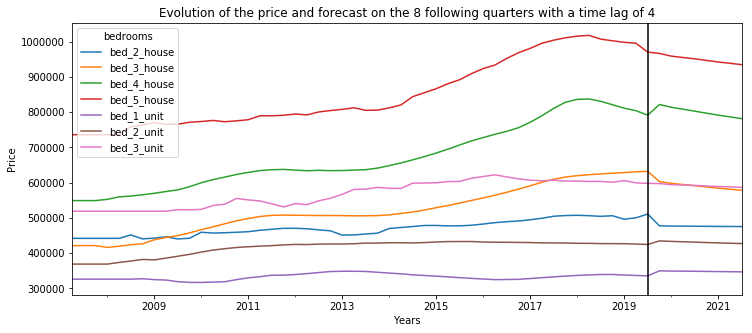

In [422]:
# Plot the forecast along with the previous values 
test_vs_pred_piv2.plot(figsize=(12,5))
plt.axvline(x='2019-09-30', color = 'black')
plt.title('Evolution of the price and forecast on the 8 following quarters with a time lag of 4')
plt.xlabel('Years')
plt.ylabel('Price')

We can observe that compared to the previous model with the lag of 2, having a lag of 4 changes the forecast. It seems that the sale price of the forecaste is still decreasing but less than with the lag of 2. Finally, they are more properties that have a sudden variation during the first forecast quarter. Overall, the forecast seems reliable.

## For the LSTM

We also want to see the impact of the time lag in the LSTM model. To do so, we will change the input in the generator from 2 to 4. Now, the model would consider 4 quarters to predict the sale price for the next quarter. 

### Process and train the model

In [416]:
# Split the training and testing set to the last 5 quarters 
train_df_piv2=df_piv[:-5]
test_df_piv2=df_piv[-5:]

# Standardize the train and test set
from sklearn.preprocessing import MinMaxScaler

scaler_piv2 = MinMaxScaler()
scaler_piv2.fit(train_df_piv2)
scaled_train_piv2 = scaler_piv2.transform(train_df_piv2)
scaled_test_piv2 = scaler_piv2.transform(test_df_piv2)

# The input in the generator will be 4 quarters. We also specify the number of inputs.
n_input = 4
n_features = 7
generator_piv2 = TimeseriesGenerator(scaled_train_piv2, scaled_train_piv2, length=n_input, batch_size=1)


# Build LSTM model
model_lstm_piv2 = Sequential()
model_lstm_piv2.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model_lstm_piv2.add(LSTM(100, activation='relu'))
model_lstm_piv2.add(Dense(7))
model_lstm_piv2.compile(optimizer='adam', loss='mae')

# Let's look to the model
model_lstm_piv2.summary()


# Fit model with 50 epochs
model_lstm_piv2.fit(generator_piv2,epochs=50)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 4, 100)            43200     
                                                                 
 lstm_35 (LSTM)              (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 7)                 707       
                                                                 
Total params: 124,307
Trainable params: 124,307
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
41/41 [==============================] - 4s 7ms/step - loss: 0.2913
Epoch 2/50
41/41 [==============================] - 0s 7ms/step - loss: 0.1397
Epoch 3/50
41/41 [==============================] - 0s 7ms/step - loss: 0.1157
Epoch 4/50
41/41 [==============================] - 0s 6ms/step - loss: 0.

### Evaluate the model

We can evaluate this new model on the test set by using the MAPE metric.

In [424]:
# The list that would take the values of the predictions
test_predictions_piv_ext = []

# Each batch is needed to predict the following quarter
first_eval_batch_piv_ext = scaled_train_piv[-n_input:]
current_batch_piv_ext = first_eval_batch_piv_ext.reshape((1, n_input, n_features))

for i in range(len(test_df_piv)):
    
    # Get the prediction value from each batch
    current_pred_piv_ext = model_lstm_piv2.predict(current_batch_piv_ext)[0]
    
    # Append the prediction into the list
    test_predictions_piv_ext.append(current_pred_piv_ext) 
    
    # Use the prediction to update the batch and remove the first value
    current_batch_piv_ext = np.append(current_batch_piv_ext[:,1:,:],[[current_pred_piv_ext]],axis=1)
    
test_predictions_piv_ext

# Inverse the transformation of the scaler to get the real value of the price 
true_predictions_piv_ext = scaler_piv.inverse_transform(test_predictions_piv_ext)

# Rename the dataframe 
pred_piv_ext = pd.DataFrame(true_predictions_piv_ext, columns = ['pred_2_house','pred_3_house',
                                                         'pred_4_house','pred_5_house',
                                                         'pred_1_unit','pred_2_unit','pred_3_unit'])
test_df_piv_ext = test_df_piv.copy()
# Update the test set to compare with the prediction
test_df_piv_ext['pred_2_house'] = pred_piv_ext['pred_2_house'].values
test_df_piv_ext['pred_3_house'] = pred_piv_ext['pred_3_house'].values
test_df_piv_ext['pred_4_house'] = pred_piv_ext['pred_4_house'].values
test_df_piv_ext['pred_5_house'] = pred_piv_ext['pred_5_house'].values
test_df_piv_ext['pred_1_unit'] = pred_piv_ext['pred_1_unit'].values
test_df_piv_ext['pred_2_unit'] = pred_piv_ext['pred_2_unit'].values
test_df_piv_ext['pred_3_unit'] = pred_piv_ext['pred_3_unit'].values

test_df_piv_ext

bedrooms,bed_2_house,bed_3_house,bed_4_house,bed_5_house,bed_1_unit,bed_2_unit,bed_3_unit,pred_2_house,pred_3_house,pred_4_house,pred_5_house,pred_1_unit,pred_2_unit,pred_3_unit
saledate,,,,,,,,,,,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0,339220.0,426970.0,603281.0,515179.906730,628249.181704,851752.737844,1.018596e+06,339588.866004,431975.866064,601647.604881
2018-12-31,506001.0,626608.0,820924.0,1002323.0,339350.0,426936.0,601167.0,516979.995448,632275.553670,859719.864430,1.023605e+06,340969.604552,432390.236933,602024.149478
2019-03-31,496133.0,628423.0,811121.0,998136.0,337838.0,426669.0,605637.0,518615.972717,636510.142129,867134.131268,1.028301e+06,342408.101677,432810.984381,602374.826382
2019-06-30,500158.0,630814.0,803925.0,995363.0,336551.0,425659.0,599339.0,520554.302667,641590.516268,875831.369560,1.033649e+06,344166.120534,433439.649502,602829.152328
2019-09-30,510712.0,631875.0,791446.0,970268.0,335449.0,424412.0,597884.0,523343.557168,648876.050962,888350.265902,1.041672e+06,346487.034672,434238.430470,603461.951832


In [425]:
comparison_data_sec_ext = {'House with 2 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,0],test_df_piv_ext['pred_2_house']),1))+'%'],
                    'House with 3 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,1],test_df_piv_ext['pred_3_house']),1))+'%'],
                   'House with 4 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,2],test_df_piv_ext['pred_4_house']),1))+'%'],
                   'House with 5 bedrooms': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,3],test_df_piv_ext['pred_5_house']),1))+'%'],
                   'Unit with 1 bedroom': [
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,4],test_df_piv_ext['pred_1_unit']),1))+'%'],
                   'Unit with 2 bedrooms':[
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,5],test_df_piv_ext['pred_2_unit']),1))+'%'],
                  'Unit with 3 bedrooms':[
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,6],test_df_piv_ext['pred_3_unit']),1))+'%']}

comparison_table_sec_ext = pd.DataFrame(data=comparison_data_sec_ext, index=['LSTM'])
comparison_table_sec_ext.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
LSTM,3.1000%,1.4000%,7.1000%,3.5000%,1.5000%,1.6000%,0.5000%


### Forecast

Now, we want to visualize the evolution and the forecast of the price when we use this time lag of 4 quarters.

In [429]:
# Standardize the all dataset
scaler_forecast_piv2 = MinMaxScaler()
scaler_forecast_piv2.fit(df_piv)
scaled_df_piv2 = scaler_forecast_piv2.transform(df_piv)

# List that would take the values of the forecast
test_predictions_lstm_forecast_piv2 = []

first_eval_batch_lstm_forecast_piv2 = scaled_df_piv2[-n_input:]
current_batch_lstm_forecast_piv2 = first_eval_batch_lstm_forecast_piv2.reshape((1, n_input, n_features))

# For the 8 next quarters, we are predicting the price
for i in range(8):
    
    # Get the prediction value from the batch
    current_pred_lstm_forecast_piv2 = model_lstm_piv2.predict(current_batch_lstm_forecast_piv2)[0]
    
    # Append the prediction into the list
    test_predictions_lstm_forecast_piv2.append(current_pred_lstm_forecast_piv2) 
    
    # Use the prediction to update the batch and remove the first value
    current_batch_lstm_forecast_piv2 = np.append(current_batch_lstm_forecast_piv2[:,1:,:],[[current_pred_lstm_forecast_piv2]],axis=1)

In [430]:
# Inverse the transformation
true_predictions_lstm_forecast_piv2 = scaler_forecast_piv2.inverse_transform(test_predictions_lstm_forecast_piv2)


# The dataframe of the prediction
pred_lstm_forecast_piv2 = pd.DataFrame(true_predictions_lstm_forecast_piv2, columns = df_piv.columns)

# We specify the 8 next quarters date
pred_lstm_forecast_piv2['date'] = date_piv

# We set the index to the date as the df_house dataframe
pred_lstm_forecast_piv2 = pred_lstm_forecast_piv2.set_index('date')

# Finally, we concatenate the dataframes 
df_cop_piv2 = df_piv.copy()
test_vs_pred_lstm_forecast_piv2=pd.concat([df_cop_piv2,pred_lstm_forecast_piv2],axis=0)


Text(0, 0.5, 'Sale Price')

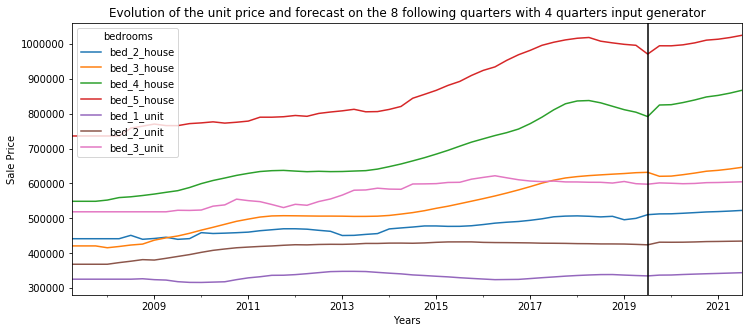

In [431]:
# Plot the forecast
test_vs_pred_lstm_forecast_piv2.plot(figsize=(12,5))
plt.axvline(x='2019-09-30', color = 'black')
plt.title('Evolution of the unit price and forecast on the 8 following quarters with 4 quarters input generator')
plt.xlabel('Years')
plt.ylabel('Sale Price')

We can observe that now, the sale price of the forecast tends to increase and not decrease. Indeed, by taking 4 previous quarters as an input, the model is not more reliable in the short term when the general trend changes. Therefore, the VARMX model would outperform the LSTM in this case.

## Comparison

Let's compare the MAPE of the two models

In [428]:
# Comparaison


comparison_data_ext = {'House with 2 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,0],predictions_piv1_ext.iloc[:,0]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,0],test_df_piv_ext['pred_2_house']),1))+'%'],
                    'House with 3 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,1],predictions_piv1_ext.iloc[:,1]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,1],test_df_piv_ext['pred_3_house']),1))+'%'],
                   'House with 4 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,2],predictions_piv1_ext.iloc[:,2]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,2],test_df_piv_ext['pred_4_house']),1))+'%'],
                   'House with 5 bedrooms': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,3],predictions_piv1_ext.iloc[:,3]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,3],test_df_piv_ext['pred_5_house']),1))+'%'],
                   'Unit with 1 bedroom': ['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,4],predictions_piv1_ext.iloc[:,4]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,4],test_df_piv_ext['pred_1_unit']),1))+'%'],
                   'Unit with 2 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,5],predictions_piv1_ext.iloc[:,5]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,5],test_df_piv_ext['pred_2_unit']),1))+'%'],
                  'Unit with 3 bedrooms':['{:.3f}'.format(round(MAPE(test_df_piv.iloc[:,6],predictions_piv1_ext.iloc[:,6]),1))+'%',
                                         '{:.4f}'.format(round(MAPE(test_df_piv.iloc[:,6],test_df_piv_ext['pred_3_unit']),1))+'%']}

comparison_table_ext = pd.DataFrame(data=comparison_data_ext, index=['VAR' , 'LSTM'])
comparison_table_ext.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,House with 2 bedrooms,House with 3 bedrooms,House with 4 bedrooms,House with 5 bedrooms,Unit with 1 bedroom,Unit with 2 bedrooms,Unit with 3 bedrooms
VAR,4.800%,2.800%,2.800%,2.100%,3.100%,2.600%,0.700%
LSTM,3.1000%,1.4000%,7.1000%,3.5000%,1.5000%,1.6000%,0.5000%
